# Tutorial for using the Fitness Landscape Exploration Sandbox

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [120]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import numpy as np
import json

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

Most FLEXS landscapes have a problem registry: a dictionary of problems, parameters, and metadata that can be used to quickly generate landscapes and set up interesting benchmarks for models and explorers.

Here we select a landscape that will maximize the negative binding energy of sequences of length 14 against a predefined RNA target.

In [3]:
problem = flexs.landscapes.rna.registry()['L14_RNA1']
pprint.pprint(problem)

{'params': {'seq_length': 14,
            'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC']},
 'starts': ['AUGGGCCGGACCCC',
            'GCCCCGCCGGAAUG',
            'UCUUGGGGACUUUU',
            'GGAUAACAAUUCAU',
            'CCCAUGCGCGAUCA']}


For RNA binding landscapes, the registry contains several starting points of diverse quality and sequence identity on which to evaluate exploration algorithms. We will call our starting point `wt` throughout this tutorial.

In [4]:
starting_sequence = problem['starts'][0]
starting_sequence

'AUGGGCCGGACCCC'

Now we instantiate the landscape and set the sequence alphabet.

In [5]:
landscape = flexs.landscapes.RNABinding(**problem['params'])
alphabet = s_utils.RNAA

You can now query the landscape for ground truth sequence fitnesses

In [6]:
landscape.get_fitness([starting_sequence])

array([0.54374688])

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes (see examples in `flexs/landscapes`).

Here we demonstrate a rosetta folding landscape, a TF binding landscape, the BERT GFP landscape, and an additive AAV packaging landscape.

In [7]:
rosetta_problem = flexs.landscapes.rosetta.registry()['3msi']
protein_landscape = flexs.landscapes.RosettaFolding(**rosetta_problem['params'])
protein_wt = protein_landscape.wt_pose.sequence()

print()
pprint.pprint(rosetta_problem)
print(f'\nWT sequence: {protein_wt}, fitness: {protein_landscape.get_fitness([protein_wt])}')

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.mac.python37.Release 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.

{'params': {'pdb_file': '/Users/stewartslocum/Downloads/FLEXS/flexs/landscapes/data/rosetta/3msi.pdb',
            'sigmoid_center': -3,
            'sigmoid_norm_value': 12},
 'starts': {'ed_12_wt': 'RAQESVVANQLIPILTHLTQKMSRRFVVTPVGIPAEDIPRLVNAQVDRAVPLGTTLMPDMDKGYAA',
            'ed_27_wt': 'MRRYSVIAYQERPINLHSTLTFNRSEVPWPVNRPASDAPRLVSMQNNRSVPLGTKLPEDPVCRYAL',
            'ed_3_wt': 'MAQASVVANQLIPINTHLTLVMMRSEVVTYVHIPAEDIPRLVSMDVNRAVPLGTTLMPDMVKGYAA',
            'ed_5_wt': 'MAQASVVFNQLIPINTHLTLVMMRFEVVTPVGCPAMDIPRLVSQQVNRAVPLGTTLMPDMVKGYAA',
            'ed_7_wt': 'WAQRSVVANQLIPINTGLTLVMMRSELVTGVGAPAEDIPRLVSMQVNRAVPLGTTNMPDMVKGYAA'}}

WT sequence: MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTT

In [16]:
tf_binding_problem = flexs.landscapes.tf_binding.registry()['SIX6_REF_R1']
tf_binding_landscape = flexs.landscapes.TFBinding(**tf_binding_problem['params'])
tf_binding_start = tf_binding_problem['starts'][5]

pprint.pprint(tf_binding_problem)
print(f'\nSequence: {tf_binding_start}, fitness: {tf_binding_landscape.get_fitness([tf_binding_start])}')

{'params': {'landscape_file': '/Users/stewartslocum/Downloads/FLEXS/flexs/landscapes/data/tf_binding/SIX6_REF_R1_8mers.txt'},
 'starts': ['GCTCGAGC',
            'GCGCGCGC',
            'TGCGCGCC',
            'ATATAGCC',
            'GTTTGGTA',
            'ATTATGTT',
            'CAGTTTTT',
            'AAAAATTT',
            'AAAAACGC',
            'GTTGTTTT',
            'TGCTTTTT',
            'AAAGATAG',
            'CCTTCTTT',
            'AAAGAGAG']}

Sequence: ATTATGTT, fitness: [0.63142704]


In [8]:
bert_gfp_landscape = flexs.landscapes.BertGFPBrightness()
bert_gfp_wt = bert_gfp_landscape.gfp_wt_sequence

print(f'WT sequence: {bert_gfp_wt}, fitness: {bert_gfp_landscape.get_fitness([bert_gfp_wt])}')

WT sequence: MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK, fitness: [3.57247734]


In [15]:
additive_aav_problem = flexs.landscapes.additive_aav_packaging.registry()['liver']
additive_aav_landscape = flexs.landscapes.AdditiveAAVPackaging(**additive_aav_problem['params'])
additive_aav_wt = additive_aav_landscape.wild_type

pprint.pprint(additive_aav_problem)
print(f'WT: {additive_aav_wt}, fitness: {additive_aav_landscape.get_fitness([additive_aav_wt])}')

{'params': {'end': 540, 'phenotype': 'liver', 'start': 450}}
WT: PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVL, fitness: [0.5]


## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use what we call a "noisy abstract model" to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to inherit from `flexs.Model` and implement `_fitness_function(sequences)` which gives you the model's estimate of a sequences fitness, and `train(sequences, labels)`.

### 2.1 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch).

In [41]:
noisy_models = [
    baselines.models.NoisyAbstractModel(landscape, signal_strength=ss)
    for ss in [1, 0.9, 0.75, 0]
]

Let's create train and test sets.

In [56]:
train_x = np.array(list(set(s_utils.generate_random_mutant(starting_sequence, 0.2*(i%5), alphabet)
                                 for i in range(0, 10000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consists of {len(train_x)} unique sequences')

test_x = np.array(list(set(s_utils.generate_random_mutant(starting_sequence, 0.2*(i%5), alphabet=alphabet)
                  for i in range(2000))))
test_y = landscape.get_fitness(test_x)

training data consists of 6870 unique sequences


And train the noisy abstract models, each of which have a different signal strength.

In [57]:
for model in noisy_models:
    model.train(train_x, train_y)

Examine the fitness distribution and edit distance distribution of the test set.

We see that the vast majority of sequences have fitness between 0.2 and 0.7. It is challenging to find sequences with fitness above 0.8.

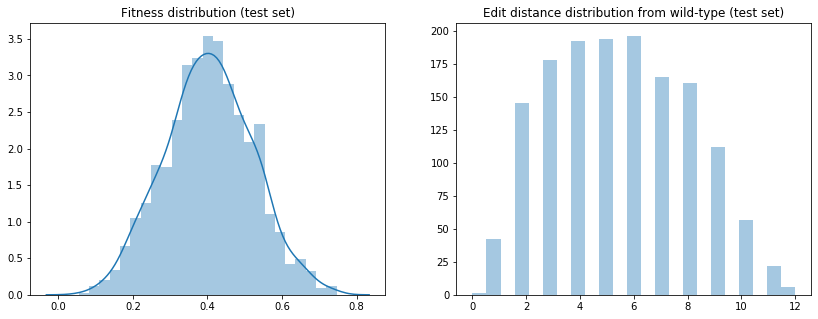

In [58]:
distances = [editdistance.eval(seq, starting_sequence) for seq in test_x]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('Fitness distribution (test set)')
sns.distplot(test_y, kde=True, ax=ax[0])
ax[1].set_title('Edit distance distribution from wild-type (test set)')
sns.distplot(distances, kde=False, ax=ax[1])
plt.show()

Now we will examine the extrapolation ability (accuracy with respect to edit distance) of noisy abstract models at different signals strengths.

In [59]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, starting_sequence) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [60]:
corrs_noisy_neighbors = [get_corr_per_distance(test_x, test_y, noisy_model.get_fitness(test_x))
                         for noisy_model in noisy_models]

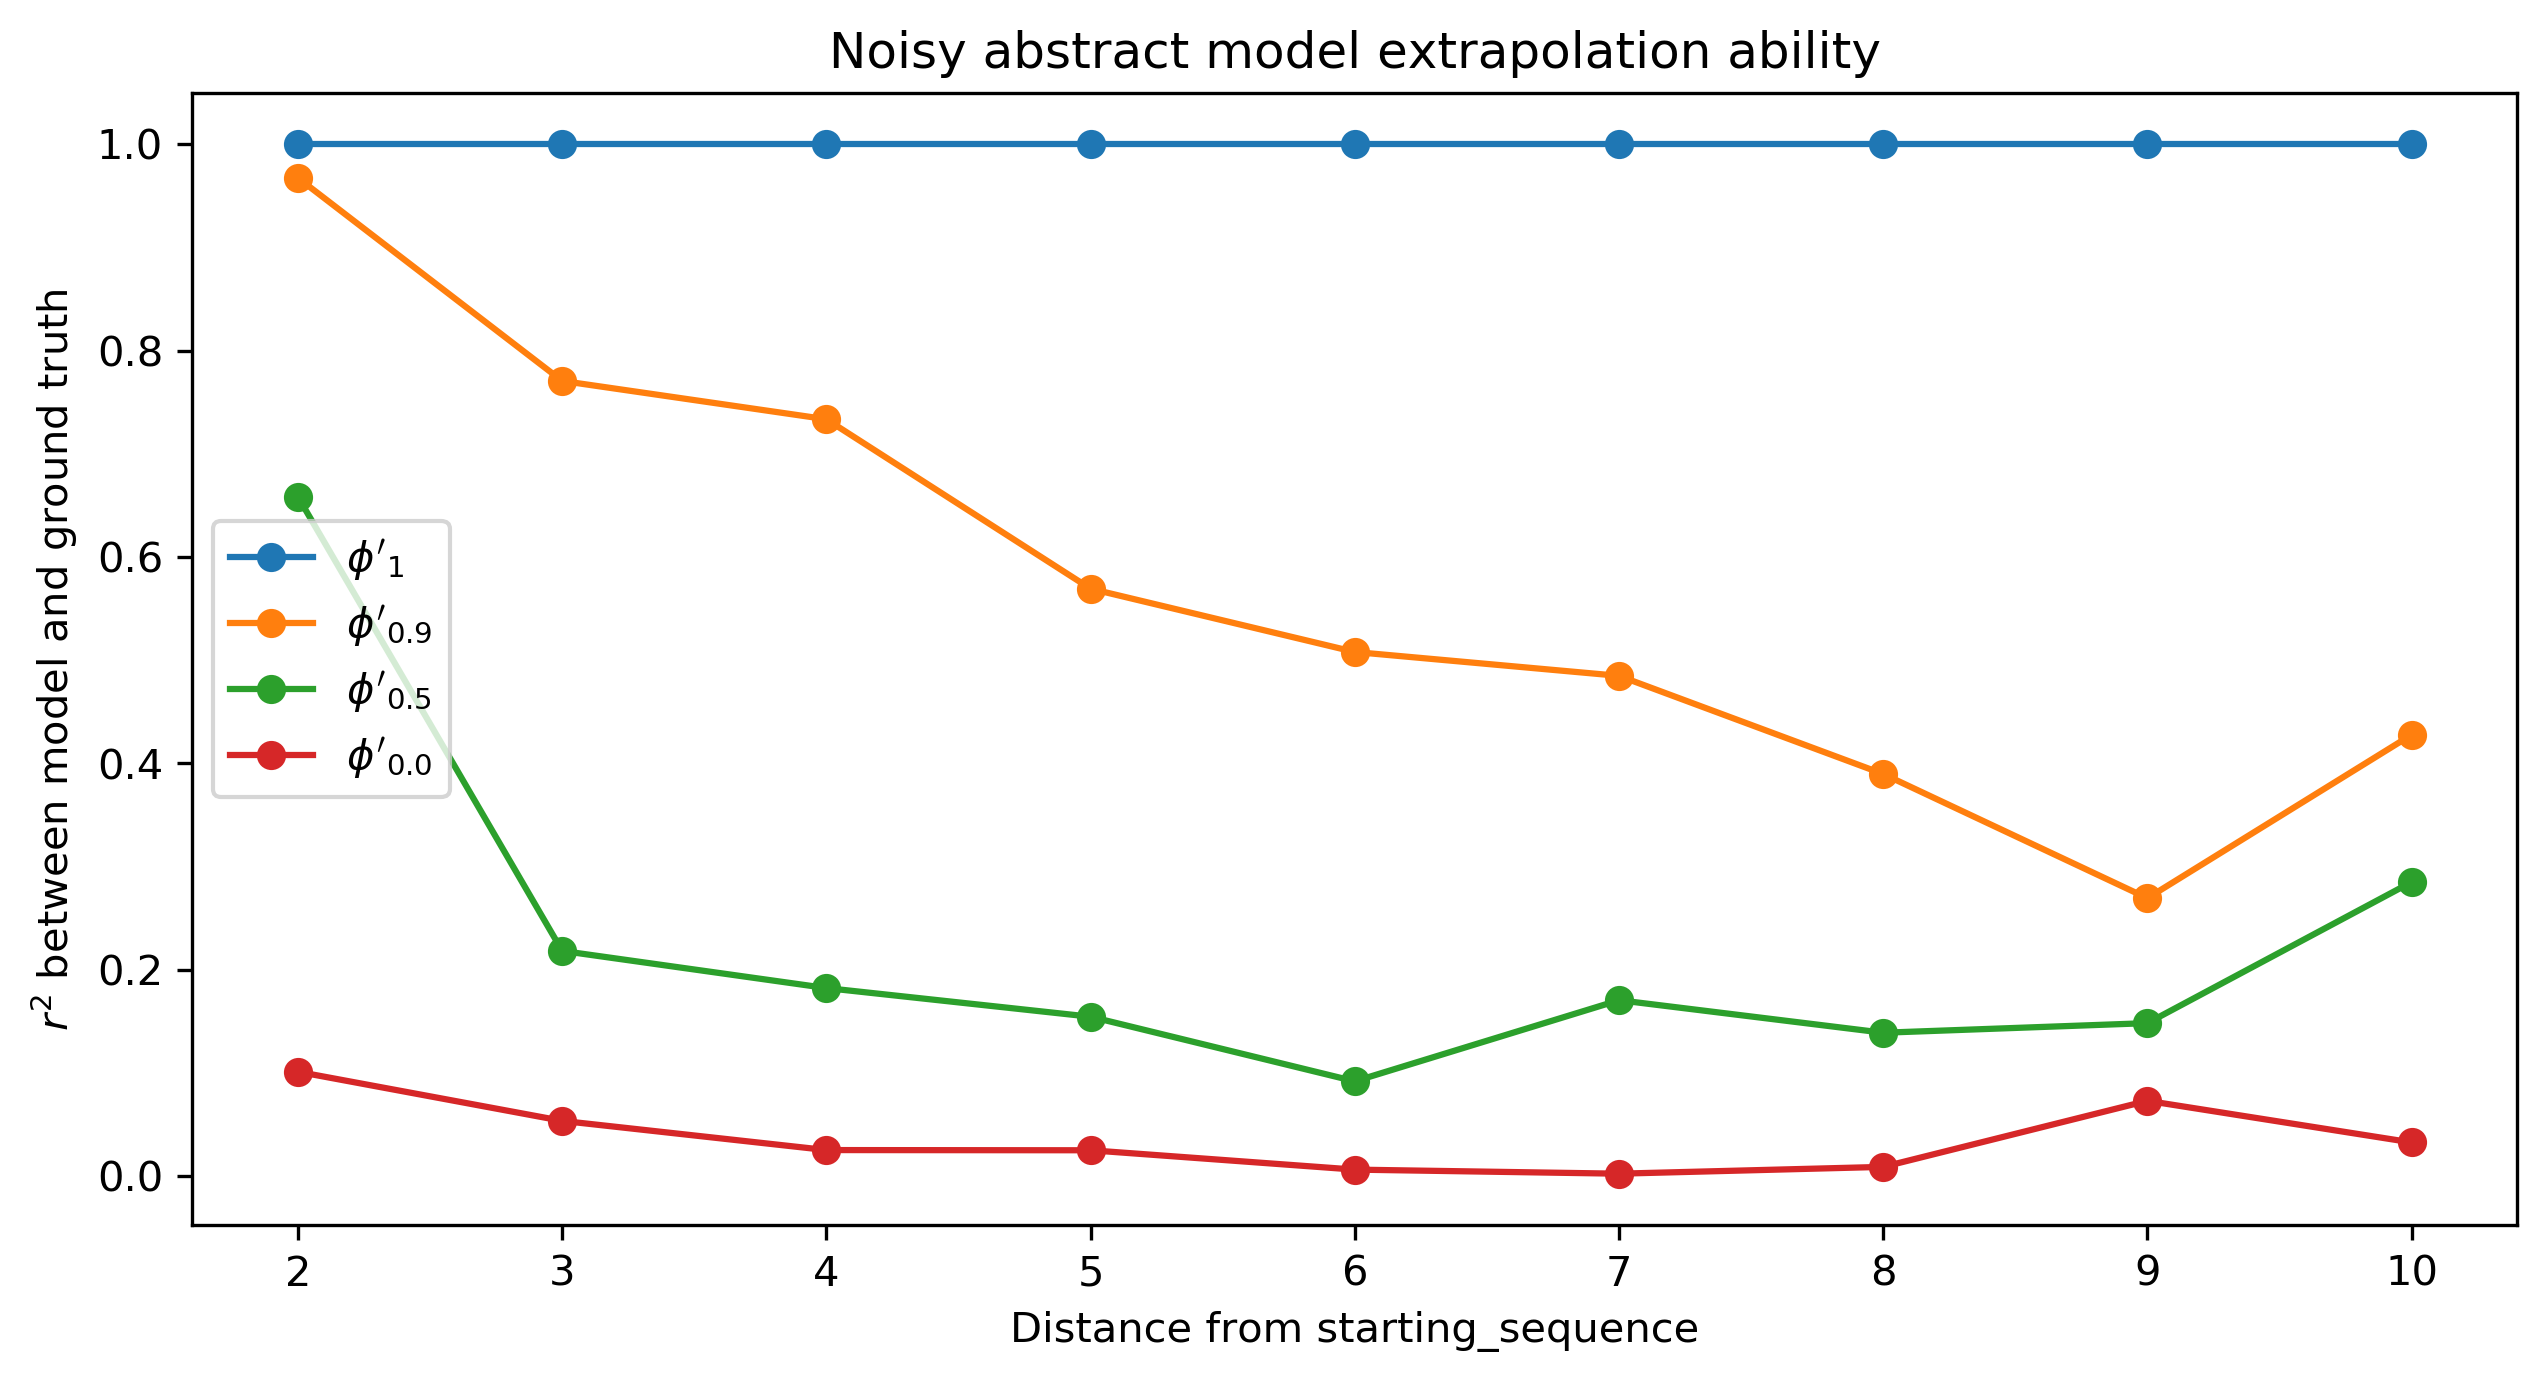

In [61]:
plt.figure(figsize=(10,5), dpi=300)
plt.title('Noisy abstract model extrapolation ability')
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.ylabel("$r^2$ between model and ground truth")
plt.xlabel("Distance from starting_sequence")
plt.legend()
plt.show()

### 2.2 Models of landscapes built from data

So far, we have looked at noisy abstract models, are basically corrupted versions of the ground truth landscape. In reality, we don't have immediate access to the ground truth, so we approximate the landscape by training a traditional machine learning model on it. Some basic architectures are provided for convenience.

In [62]:
linear_regression = baselines.models.LinearRegression(alphabet=alphabet)
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(test_x)
corrs_linear = get_corr_per_distance(test_x, test_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, test_y)[0]**2}")

Overall correlation: 0.7799342430264347


In [63]:
random_forest = baselines.models.RandomForest(alphabet=alphabet)
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(test_x)
corrs_rf = get_corr_per_distance(test_x, test_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, test_y)[0]**2}")

Overall correlation: 0.7815008588026602


In [64]:
mlp = baselines.models.MLP(len(starting_sequence), hidden_size=100, alphabet=alphabet, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(test_x)
corrs_mlp = get_corr_per_distance(test_x, test_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, test_y)[0]**2}")

Overall correlation: 0.8024727834466838


In [65]:
cnn = baselines.models.CNN(len(starting_sequence), num_filters=32, hidden_size=100, alphabet=alphabet, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(test_x)
corrs_cnn = get_corr_per_distance(test_x, test_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, test_y)[0]**2}")

Overall correlation: 0.8543849028610628


We can easily ensemble these models of the landscape as well. 

In [66]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(len(starting_sequence), alphabet=alphabet, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(test_x)
corrs_cnn_ensemble = get_corr_per_distance(test_x, test_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, test_y)[0]**2}")

Overall correlation: 0.8764008908318737


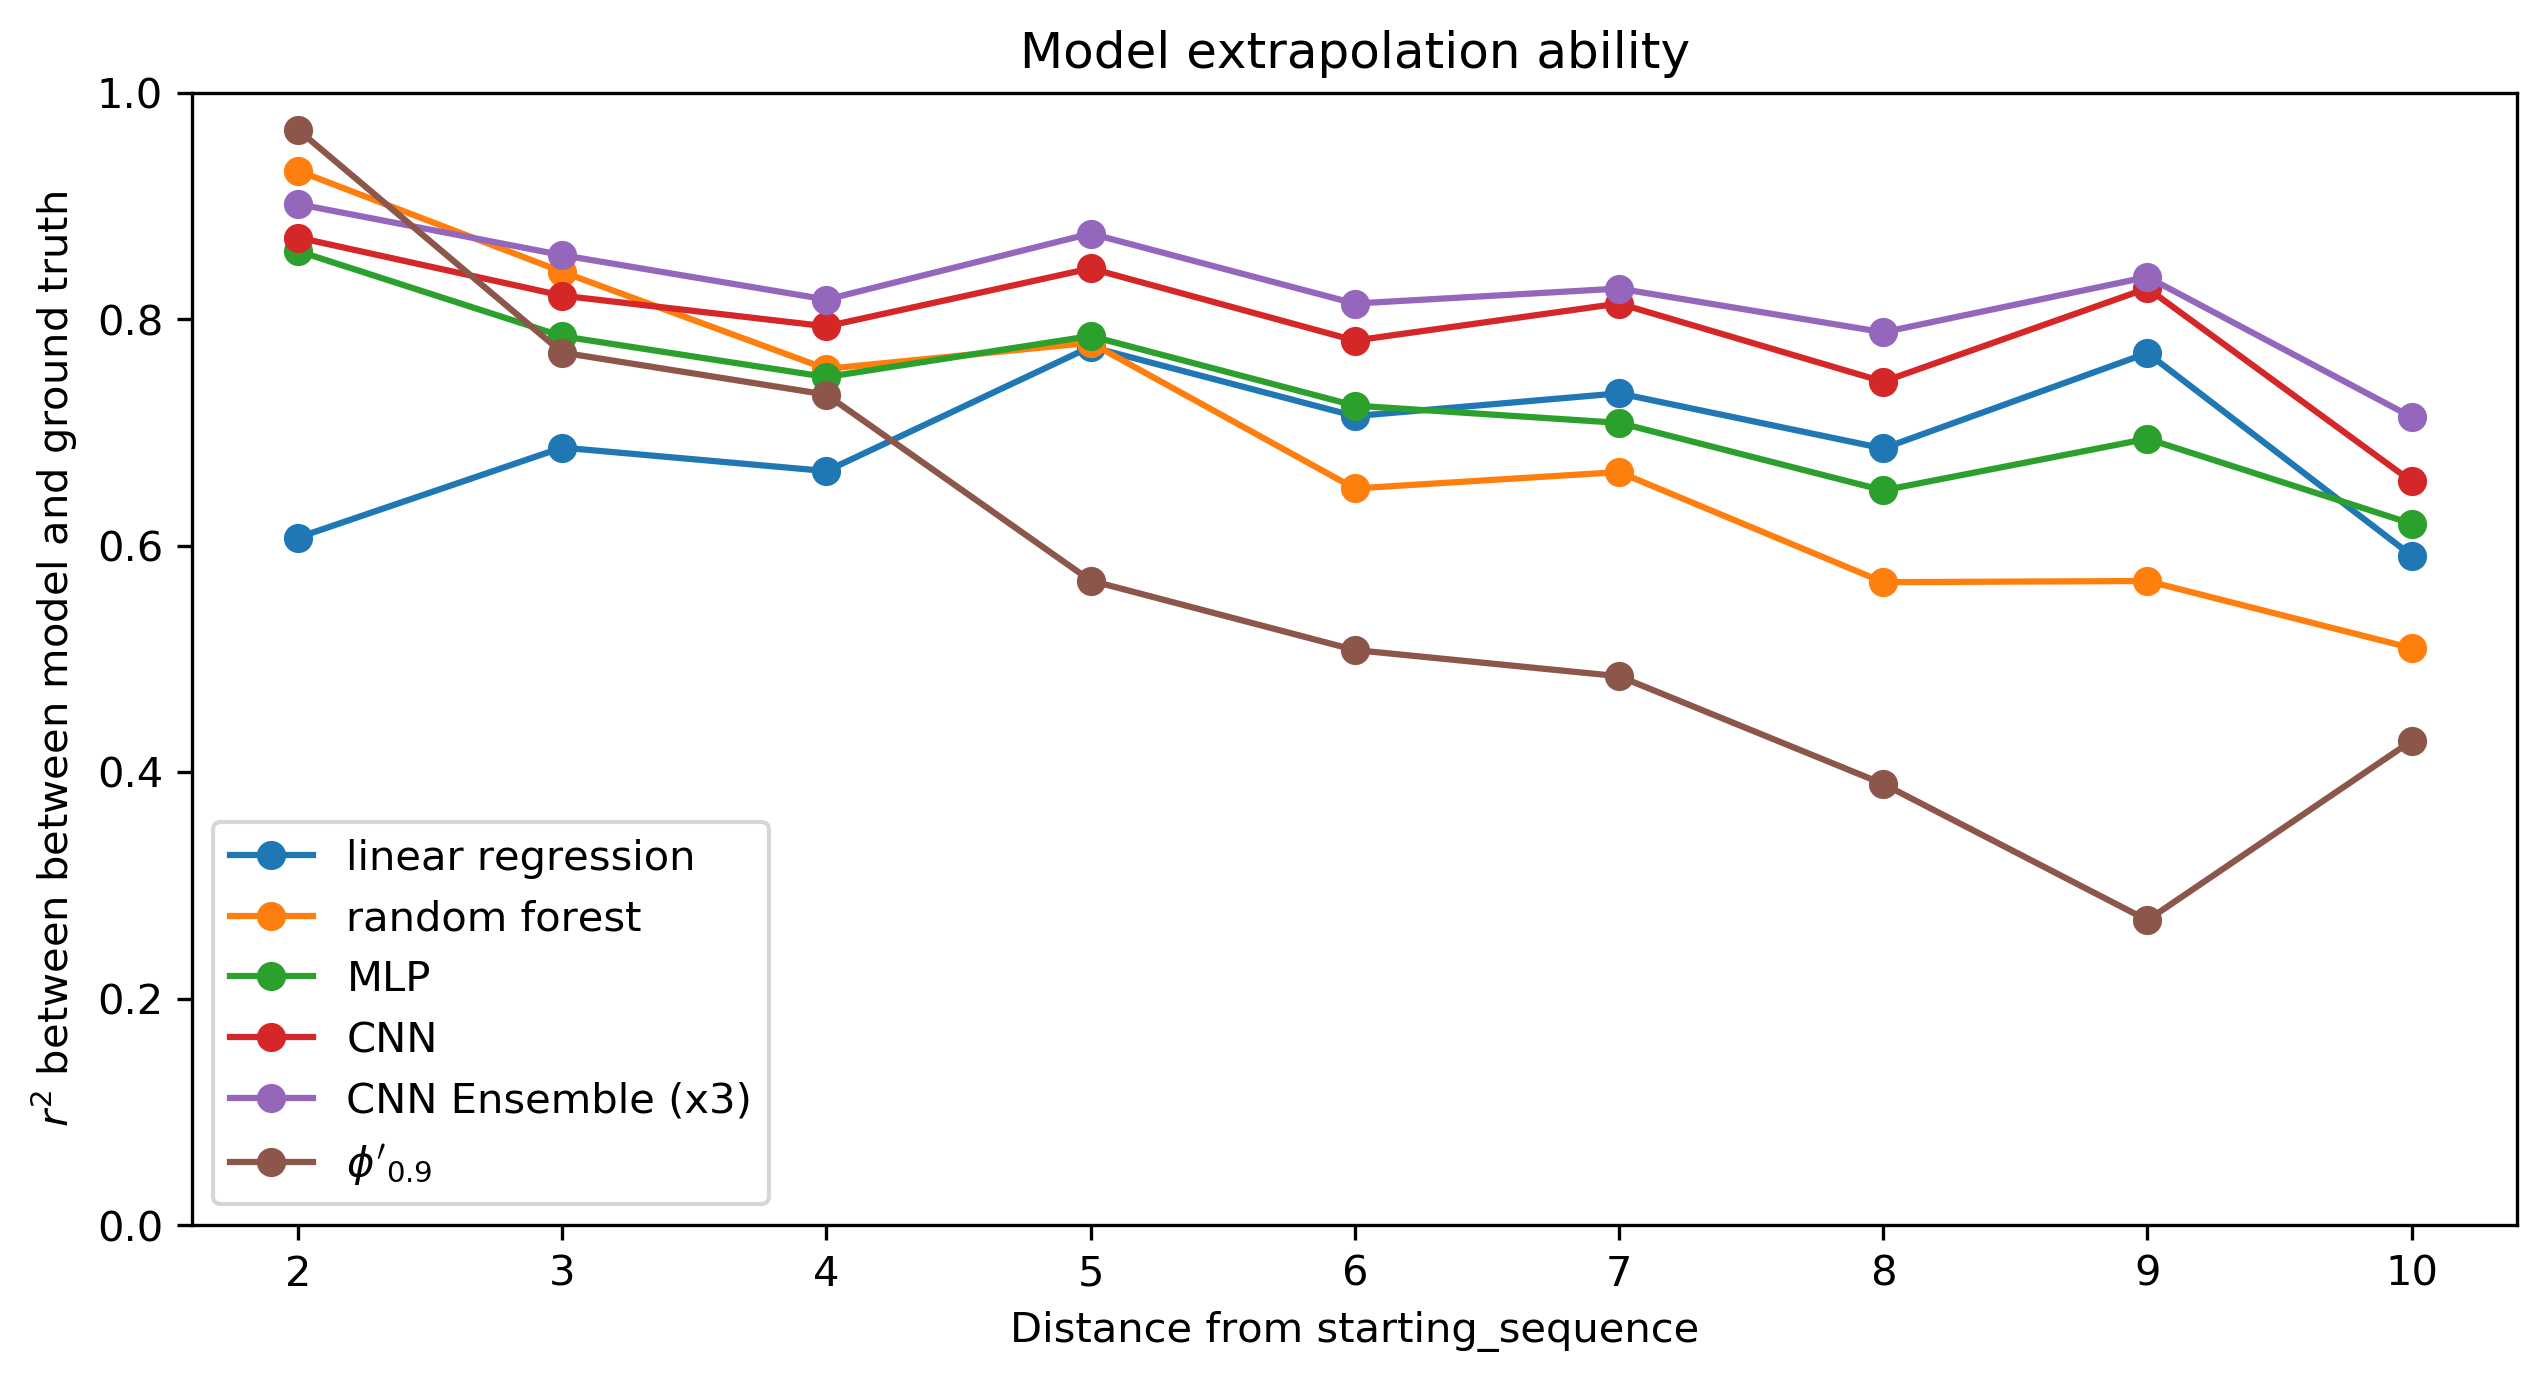

In [67]:
plt.figure(figsize=(10,5), dpi=300)
plt.title('Model extrapolation ability')
plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.ylabel("$r^2$ between between model and ground truth")
plt.xlabel("Distance from starting_sequence")
plt.legend()
plt.ylim(0, 1)
plt.show()

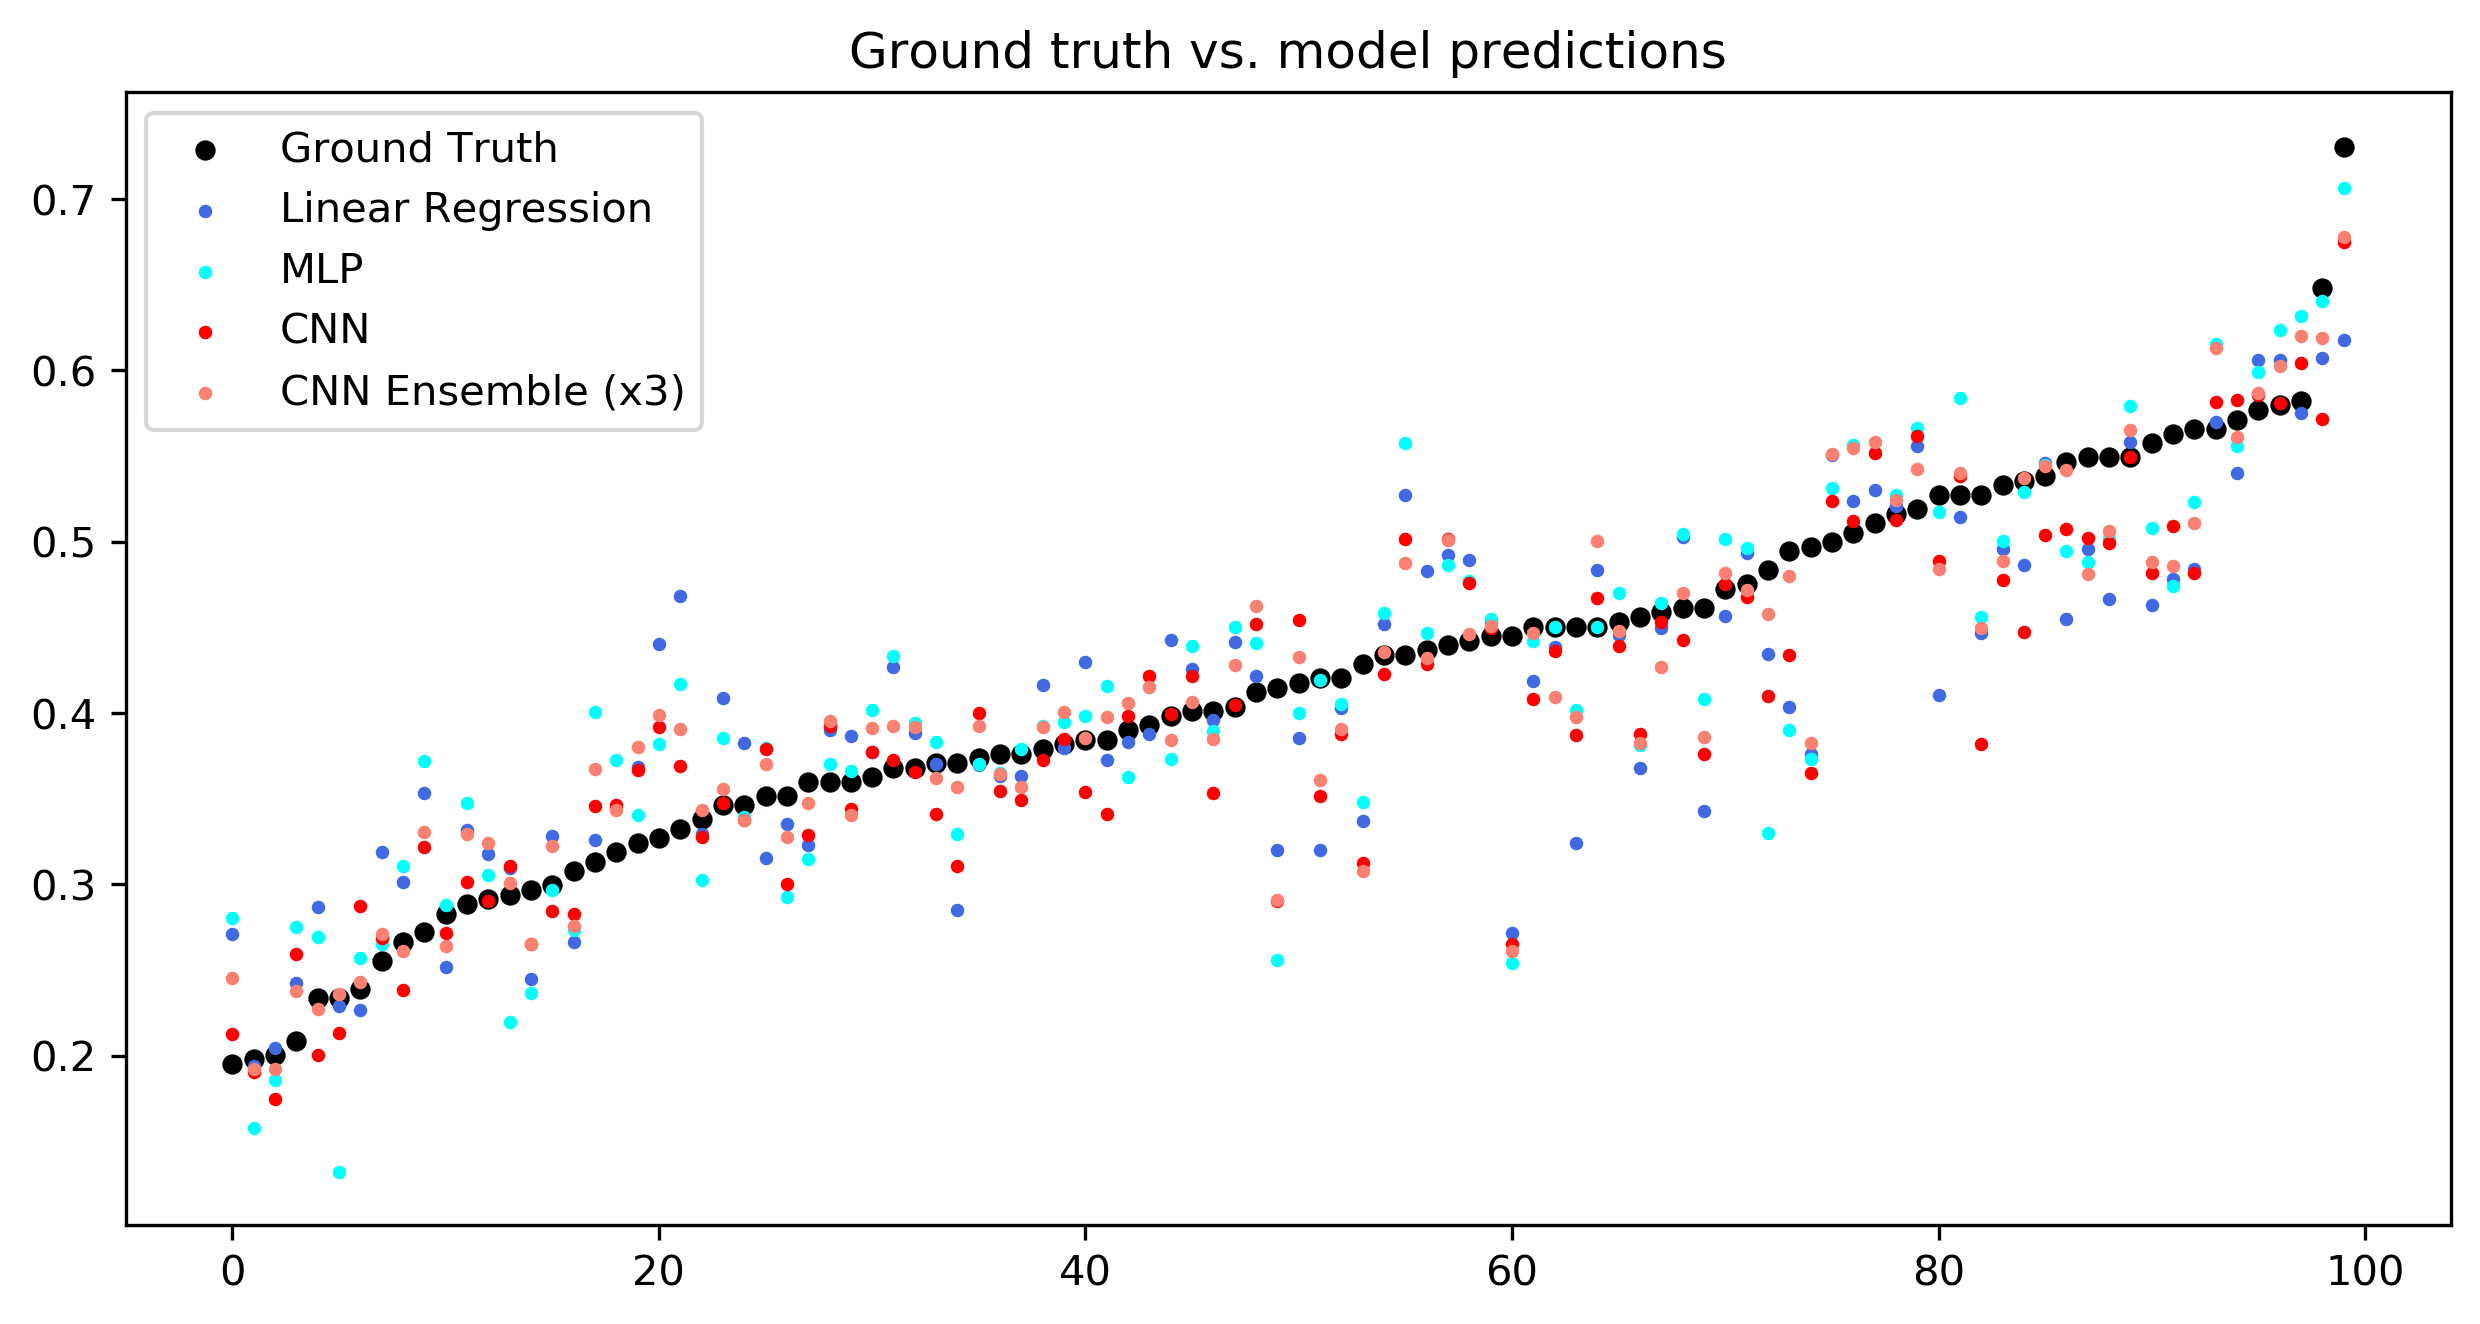

In [68]:
sort_order = np.argsort(test_y[:100])

plt.figure(figsize=(10,5), dpi=300)
plt.title('Ground truth vs. model predictions')
plt.scatter(range(len(sort_order)), test_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from a base `Explorer` which performs some house-keeping tasks. To implement a new explorer, just implement the `propose_sequences` method, which suggest new sequences at each round.

Start with a simple explorer that does random search.

In [163]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

random_explorer = baselines.explorers.Random(
    cnn,
    rounds=10,
    mu=1,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=2000,
    alphabet=alphabet
)

- `sequences_batch_size` denotes the experimental batch size per round
- `model_queries_per_batch` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

The `run` method returns a dataframe with the sequences and some other important information.

In [164]:
random_sequences, metadata = random_explorer.run(landscape)
random_sequences

round: 0, top: 0.5437468768175177, time: 0.000159s
round: 1, top: 0.7002800956120209, time: 1.303656s
round: 2, top: 0.757950231608919, time: 0.349407s
round: 3, top: 0.757950231608919, time: 0.427167s
round: 4, top: 0.757950231608919, time: 0.511561s
round: 5, top: 0.757950231608919, time: 0.622563s
round: 6, top: 0.757950231608919, time: 0.724572s
round: 7, top: 0.757950231608919, time: 0.845697s
round: 8, top: 0.757950231608919, time: 0.890370s
round: 9, top: 0.757950231608919, time: 0.967838s
round: 10, top: 0.757950231608919, time: 1.071496s


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,AUGGGCCGGACCCC,NaN,0.543747,0,0,1
0,AUUGGCCGACCCCC,0.400802,0.535508,1,2001,101
1,AAGGGCCGGCCCCC,0.412525,0.628879,1,2001,101
2,AUUGGCCGGCCCCC,0.387664,0.598671,1,2001,101
3,ACAGGCCGGGCCCC,0.346022,0.571209,1,2001,101
...,...,...,...,...,...,...
95,UGGAGCAGGGCCUC,0.407368,0.439391,10,20010,1001
96,CUGGGCUGGCCCCC,0.643936,0.683803,10,20010,1001
97,AUGAGCCGGACAUC,0.374204,0.464107,10,20010,1001
98,UUCGGACGGUCUCC,0.432443,0.458615,10,20010,1001


We will compare performance among several explorers over 10 rounds with a sequences_batch_size of 100 and model_queries_per_batch size of 1000.

In [74]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    cnn,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=2000,
    alphabet=alphabet
)

In [75]:
adalead_sequences, metadata = adalead_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000193s
round: 1, top: 0.7524578177503418, time: 2.411555s
round: 2, top: 0.7936507645510489, time: 2.118706s
round: 3, top: 0.887021433490077, time: 2.141853s
round: 4, top: 0.925468225741036, time: 1.999384s
round: 5, top: 0.9364529486991093, time: 1.953681s
round: 6, top: 0.9364529486991093, time: 2.067147s
round: 7, top: 0.9364529486991093, time: 2.259590s
round: 8, top: 0.9364529486991093, time: 2.267062s
round: 9, top: 0.9364529486991093, time: 2.588694s
round: 10, top: 0.9364529486991093, time: 2.724679s


In [76]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    cnn,
    
    population_size=20,
    parent_selection_strategy='wright-fisher', # wright-fisher model decides who gets to 'mate'
    beta=0.01,
    children_proportion=0.2,

    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=alphabet
)

In [77]:
genetic_algo_sequences, metadata = genetic_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000205s
round: 1, top: 0.5492392906760948, time: 17.108628s
round: 2, top: 0.5931784444060906, time: 19.852776s
round: 3, top: 0.6892953202744071, time: 21.431447s
round: 4, top: 0.7195034917375004, time: 22.001270s
round: 5, top: 0.8046355398886628, time: 23.497563s
round: 6, top: 0.8046355398886628, time: 23.081081s
round: 7, top: 0.8046355398886628, time: 23.159544s
round: 8, top: 0.8046355398886628, time: 22.230888s
round: 9, top: 0.8403361252103332, time: 22.201118s
round: 10, top: 0.889767692798906, time: 22.522752s


In [81]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    flexs.LandscapeAsModel(landscape),
    
    population_size=10,
    max_iter=200,
    
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=alphabet
)

In [82]:
cmaes_sequences, metadata = cmaes_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000311s
round: 1, top: 0.7304882670751143, time: 0.553897s
round: 2, top: 0.7332344740044028, time: 0.544251s
round: 3, top: 0.889767692798906, time: 0.552975s
round: 4, top: 0.889767692798906, time: 0.506514s
round: 5, top: 0.889767692798906, time: 0.563082s
round: 6, top: 0.9062448296155565, time: 0.535511s
round: 7, top: 0.9062448296155565, time: 0.515759s
round: 8, top: 0.9062448296155565, time: 0.485313s
round: 9, top: 0.9062448296155565, time: 0.500184s
round: 10, top: 0.9062448296155565, time: 0.502849s


In [159]:
dynappo_explorer = baselines.explorers.DynaPPO(  # DynaPPO has its own default ensemble model, so don't use CNN
    landscape=landscape,
    env_batch_size=10,
    num_model_rounds=10,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=alphabet,
)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


In [160]:
dynappo_sequences, metadata = dynappo_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000160s
round: 1, top: 0.55747785908442, time: 10.642786s
round: 2, top: 0.7030263025413095, time: 9.522739s
round: 3, top: 0.7030263025413095, time: 13.578535s
round: 4, top: 0.7030263025413095, time: 19.782682s
round: 5, top: 0.7524578177503418, time: 21.644764s
round: 6, top: 0.7524578177503418, time: 25.973212s
round: 7, top: 0.7524578177503418, time: 26.150545s
round: 8, top: 0.7524578177503418, time: 26.589795s
round: 9, top: 0.7524578177503418, time: 26.826482s
round: 10, top: 0.7524578177503418, time: 27.082282s


In [165]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

vae = baselines.explorers.VAE(len(starting_sequence), alphabet=alphabet, epochs=10, verbose=False)

cbas_explorer = baselines.explorers.CbAS(
    model=cnn,
    generator=vae,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=2000,
    alphabet=alphabet,
)

In [ ]:
cbas_sequences, metadata = cbas_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000216s


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.7167572848082119, time: 0.389839s


In [115]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

# This is `EVO_BO` in the paper, an evolutionary algorithm using
# ensembled models (when provided) to estimate uncertainty
bo_explorer = baselines.explorers.BO(
    model=cnn,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=alphabet,
)

In [116]:
bo_sequences, metadata = bo_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000172s
round: 1, top: 0.6426099596151229, time: 4.130466s
round: 2, top: 0.6426099596151229, time: 3.902688s
round: 3, top: 0.6426099596151229, time: 4.168476s
round: 4, top: 0.6426099596151229, time: 4.324327s
round: 5, top: 0.6426099596151229, time: 4.491849s
round: 6, top: 0.6892953202744071, time: 4.581134s
round: 7, top: 0.6892953202744071, time: 5.006634s
round: 8, top: 0.6892953202744071, time: 5.020242s
round: 9, top: 0.6892953202744071, time: 5.861588s
round: 10, top: 0.6892953202744071, time: 5.353233s


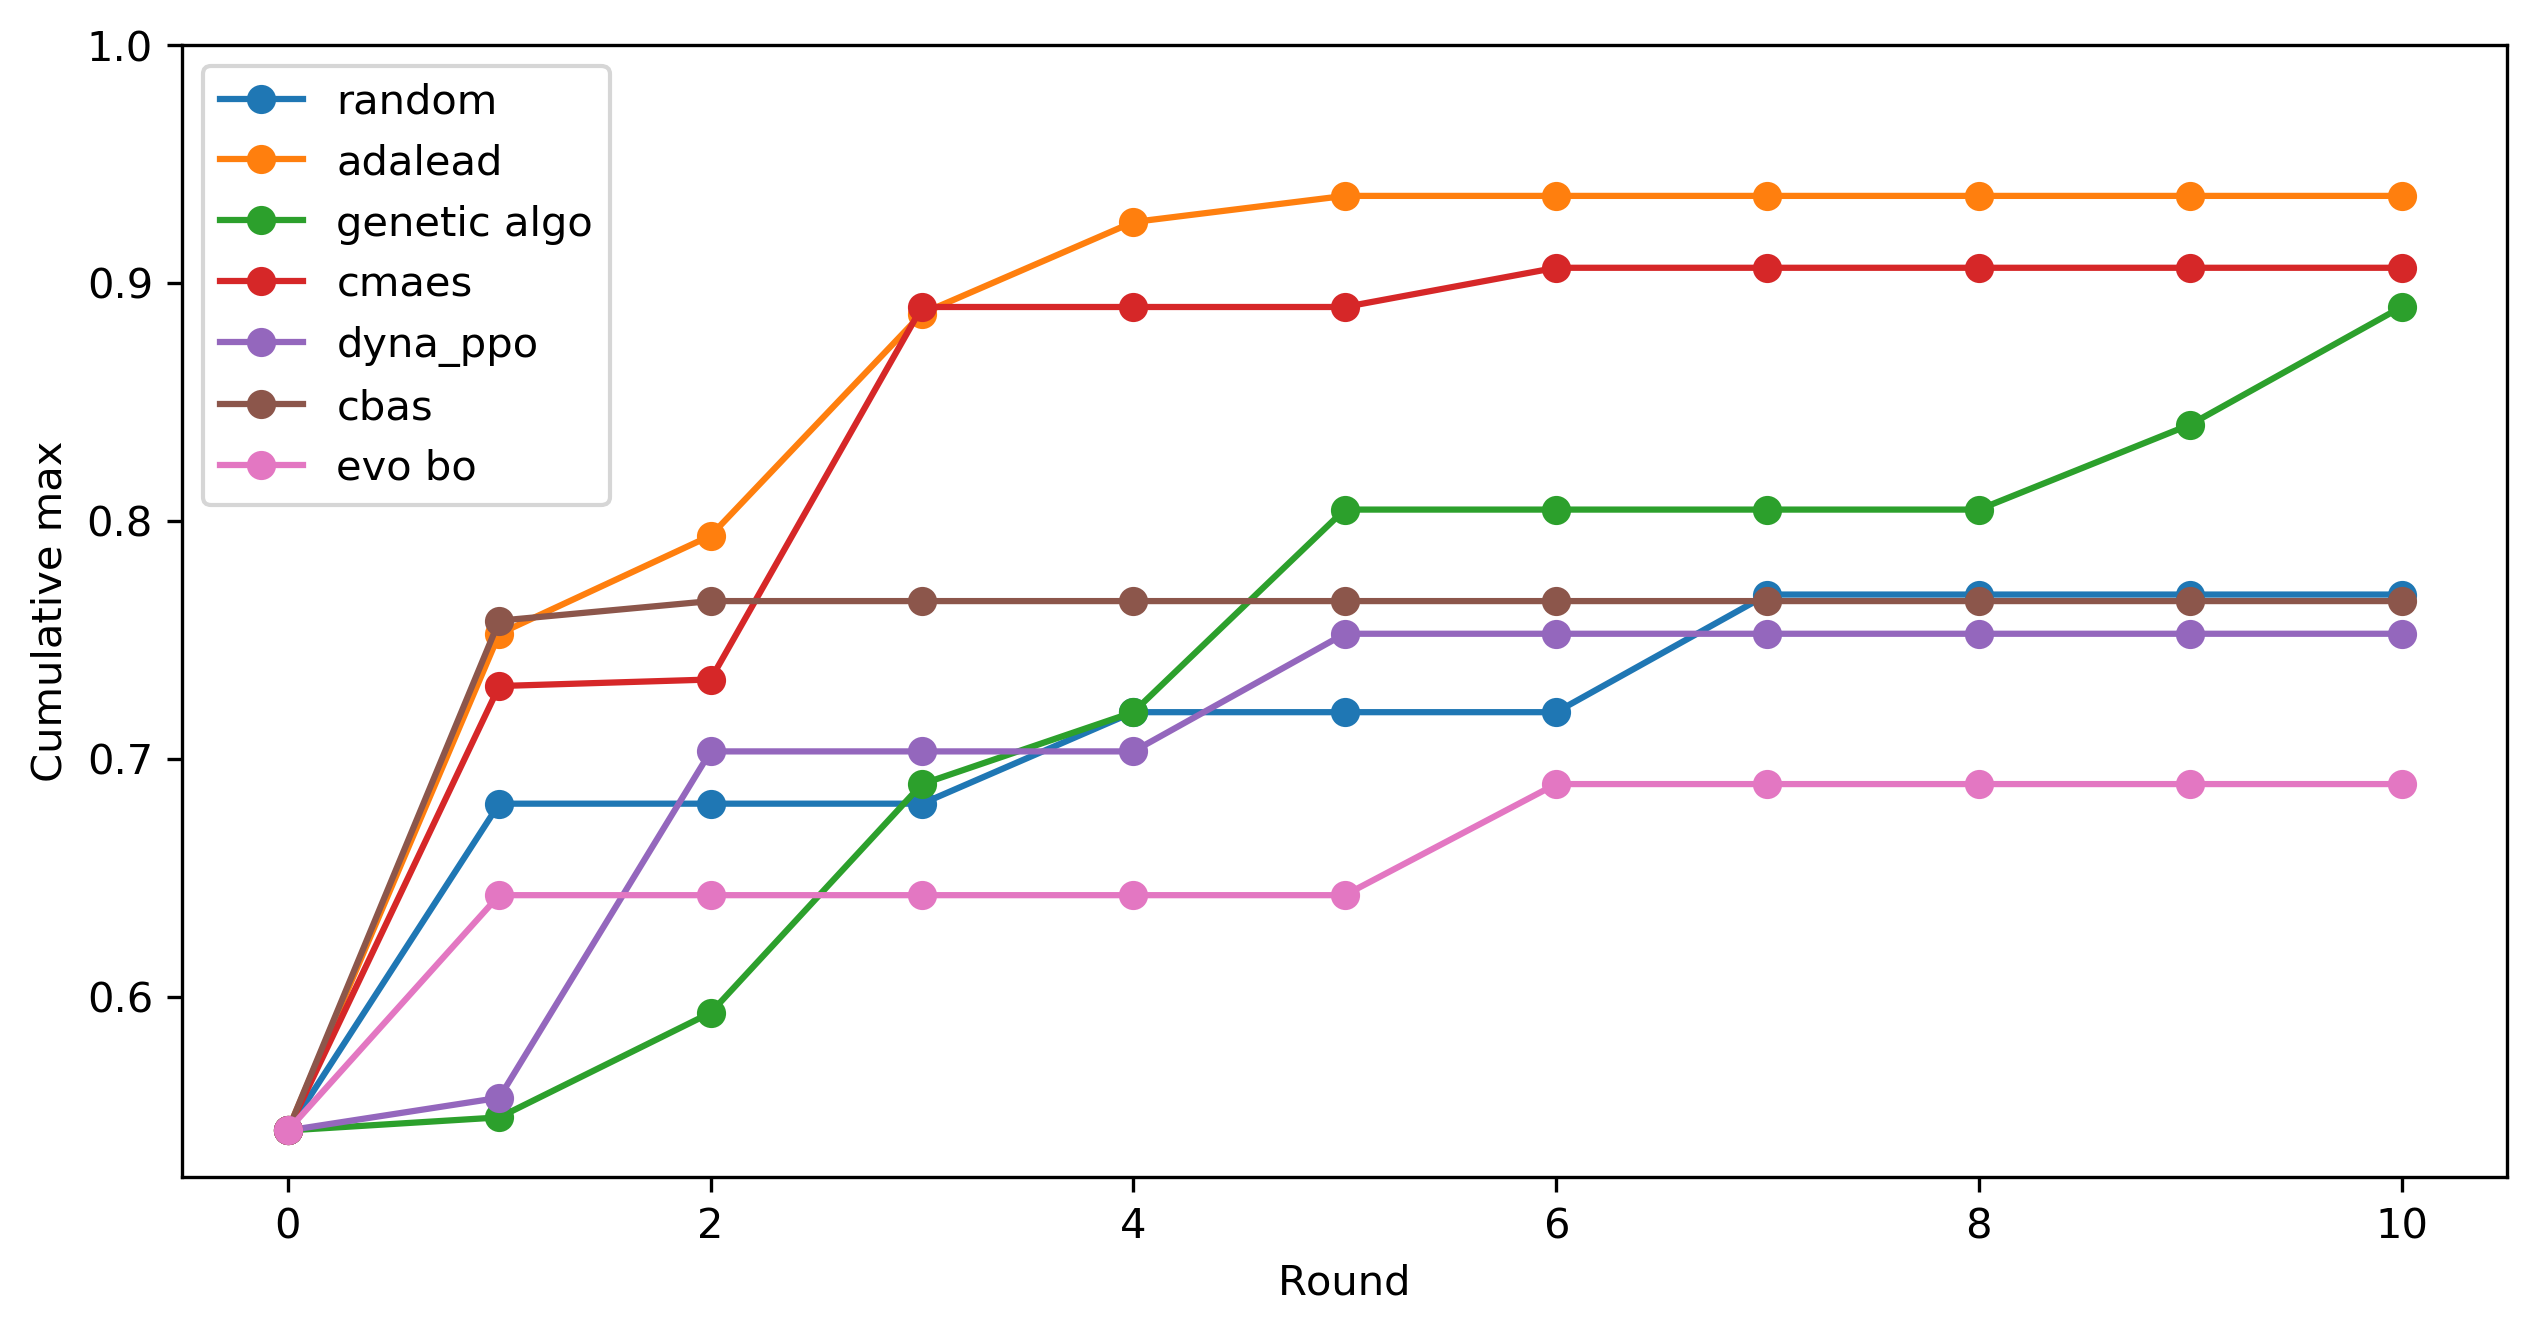

In [162]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(11), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(11), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(11), cumulative_max_per_round(genetic_algo_sequences), 'o-', label="genetic algo")
plt.plot(range(11), cumulative_max_per_round(cmaes_sequences), 'o-', label="cmaes")
plt.plot(range(11), cumulative_max_per_round(dynappo_sequences), 'o-', label="dyna_ppo")
plt.plot(range(11), cumulative_max_per_round(cbas_sequences), 'o-', label="cbas")
plt.plot(range(11), cumulative_max_per_round(bo_sequences), 'o-', label="evo bo")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
plt.ylim(None, 1)
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


The `flexs.evaluate` module can be used run tests aimed at different properties of the explorer. 

Tests include:
- `robustness`: shows how explorer performance changes with model quality (noisy abstract models at different signal strengths).
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample

In most cases, you want to set the `log_dir` argument on the explorer to write output to a .csv file to analyze later.

Here we will test out Adalead's robustness to varying model quality.

In [132]:
def make_explorer(model, signal_strength):
    return baselines.explorers.Adalead(
            model,
            rounds=5,
            mu=1,
            starting_sequence=starting_sequence,
            sequences_batch_size=100,
            model_queries_per_batch=1000,
            alphabet=alphabet,
            log_file=f'robustness/adalead/{signal_strength}.csv'
        )

results = flexs.evaluate.robustness(landscape, make_explorer, signal_strengths=[0, 0.5, 0.75, 0.9, 1])

Evaluating for robustness with model accuracy; signal_strength: 0
round: 0, top: 0.5437468768175177, time: 0.001216s
round: 1, top: 0.7304882670751143, time: 0.760548s
round: 2, top: 0.7634425930879556, time: 1.023346s
round: 3, top: 0.7634425930879556, time: 1.233608s
round: 4, top: 0.7716812138758213, time: 1.327146s
round: 5, top: 0.889767692798906, time: 1.342075s
Evaluating for robustness with model accuracy; signal_strength: 0.5
round: 0, top: 0.5437468768175177, time: 0.001503s
round: 1, top: 0.7002800956120209, time: 0.681261s
round: 2, top: 0.7963969714803375, time: 0.953963s
round: 3, top: 0.8266051429434308, time: 1.320071s
round: 4, top: 0.8815290196314998, time: 1.473321s
round: 5, top: 0.8815290196314998, time: 1.844178s
Evaluating for robustness with model accuracy; signal_strength: 0.75
round: 0, top: 0.5437468768175177, time: 0.001020s
round: 1, top: 0.7854121961427237, time: 0.790146s
round: 2, top: 0.9309606395996132, time: 1.146137s
round: 3, top: 0.9913768777667188

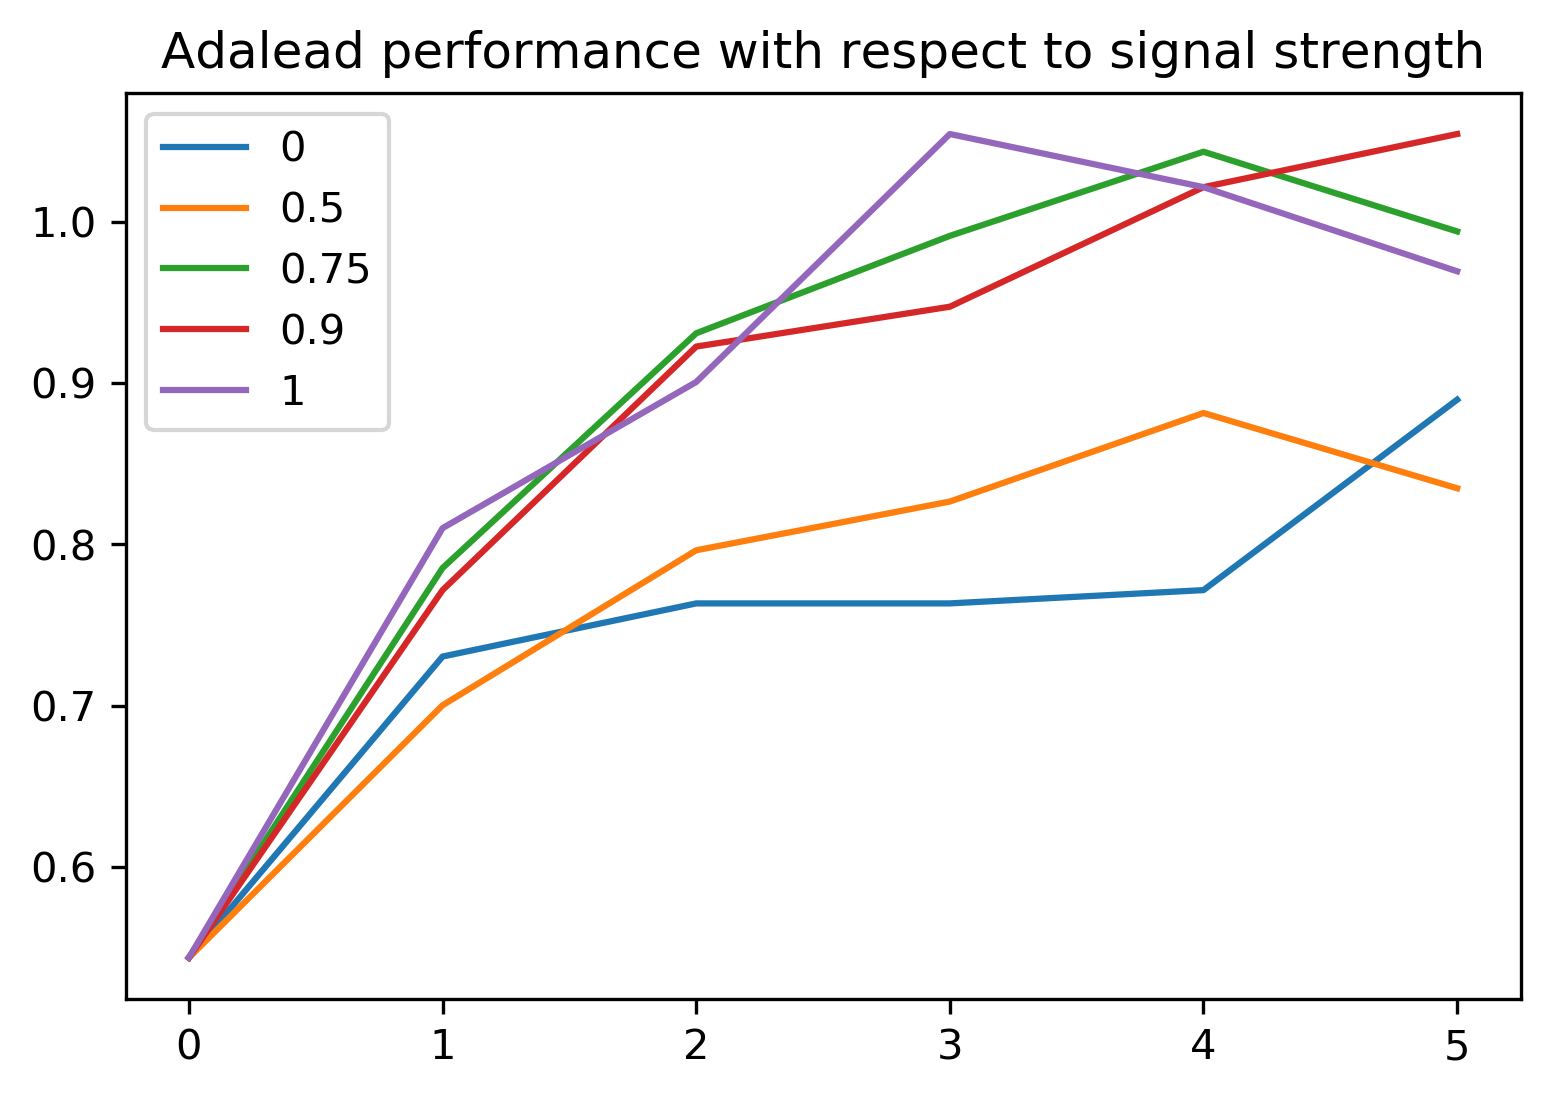

In [133]:
plt.figure(dpi=300)
plt.title('Adalead performance with respect to signal strength')

# The output file contains metadata on the first line
for signal_strength in [0, 0.5, 0.75, 0.9, 1]:
    with open(f'robustness/adalead/{signal_strength}.csv') as f:
        metadata = json.loads(next(f))
        data = pd.read_csv(f)
    
    rounds = data['round'].unique()
    
    plt.plot(rounds, [data[data['round'] == r]['true_score'].max() for r in rounds], label=signal_strength)

plt.legend()